# Import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import loguniform
import os

from sklearn import metrics
from imblearn.combine import SMOTEENN, SMOTETomek
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, roc_curve
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import auc, RocCurveDisplay

import warnings

In [2]:
warnings.filterwarnings('ignore')#

# Read csv, EDA

## Read csv, drop column

In [4]:
current_campaign = pd.read_csv('zadanie_rekrutacyjne_ds\current_campaign.csv', sep=';')
current_campaign.head(5)

,client_id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,1,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,2,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,3,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,4,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,5,33.0,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
# drop client_id column
current_campaign.drop(columns='client_id', inplace=True)
current_campaign.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33.0,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Analysis, visualization

In [6]:
current_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45208 non-null  float64
 1   job        45211 non-null  object 
 2   marital    45208 non-null  object 
 3   education  45211 non-null  object 
 4   default    45211 non-null  object 
 5   balance    45211 non-null  int64  
 6   housing    45211 non-null  object 
 7   loan       45211 non-null  object 
 8   contact    45211 non-null  object 
 9   day        45211 non-null  int64  
 10  month      45211 non-null  object 
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  y          45211 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 4.8+ MB


In [7]:
current_campaign.isnull().sum()

age          3
job          0
marital      3
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [8]:
print('*** Unique values in each column ***')
print('-' * 80)
for i in current_campaign.select_dtypes('object').columns:
    print(i, current_campaign[i].unique())

*** Unique values in each column ***
--------------------------------------------------------------------------------
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced' nan]
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
y ['no' 'yes']


In [9]:
current_campaign.describe()

,age,balance,day,duration,campaign
count,45208.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.935653,1362.272058,15.806419,258.163080,2.763841
std,10.643147,3044.765829,8.322476,257.527812,3.098021
min,-57.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000
max,160.000000,102127.000000,31.000000,4918.000000,63.000000


In [10]:
current_campaign[(current_campaign['age'] < 18) | (current_campaign['age'] > 100)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
42,160.0,blue-collar,married,unknown,no,104,yes,no,unknown,5,may,22,1,no
19050,-57.0,retired,divorced,tertiary,no,241,no,yes,cellular,5,aug,146,1,no


In the "age" column we have min age **-57** and max age **160**. In total, we have 2 rows with such values, so we can just delete them

In [11]:
current_campaign[(current_campaign['duration'] > 3000)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
2386,45.0,blue-collar,married,secondary,no,66,yes,no,unknown,13,may,3366,3,no
4382,34.0,blue-collar,married,primary,no,183,yes,no,unknown,19,may,3078,4,no
6451,44.0,services,divorced,secondary,no,51,yes,yes,unknown,27,may,3094,2,yes
9947,59.0,management,married,secondary,no,1321,no,no,unknown,9,jun,3881,3,yes
12347,28.0,admin.,single,secondary,no,-7,no,yes,unknown,26,jun,3183,2,yes
19639,37.0,blue-collar,married,tertiary,no,359,no,yes,cellular,7,aug,3422,2,no
21113,43.0,self-employed,married,tertiary,no,423,no,no,cellular,14,aug,3322,2,no
24044,36.0,self-employed,single,tertiary,no,-103,yes,yes,telephone,17,oct,3253,1,yes
24095,30.0,admin.,married,secondary,no,1310,no,no,telephone,27,oct,3284,1,no
24148,59.0,technician,married,tertiary,no,6573,yes,no,telephone,10,nov,4918,1,no


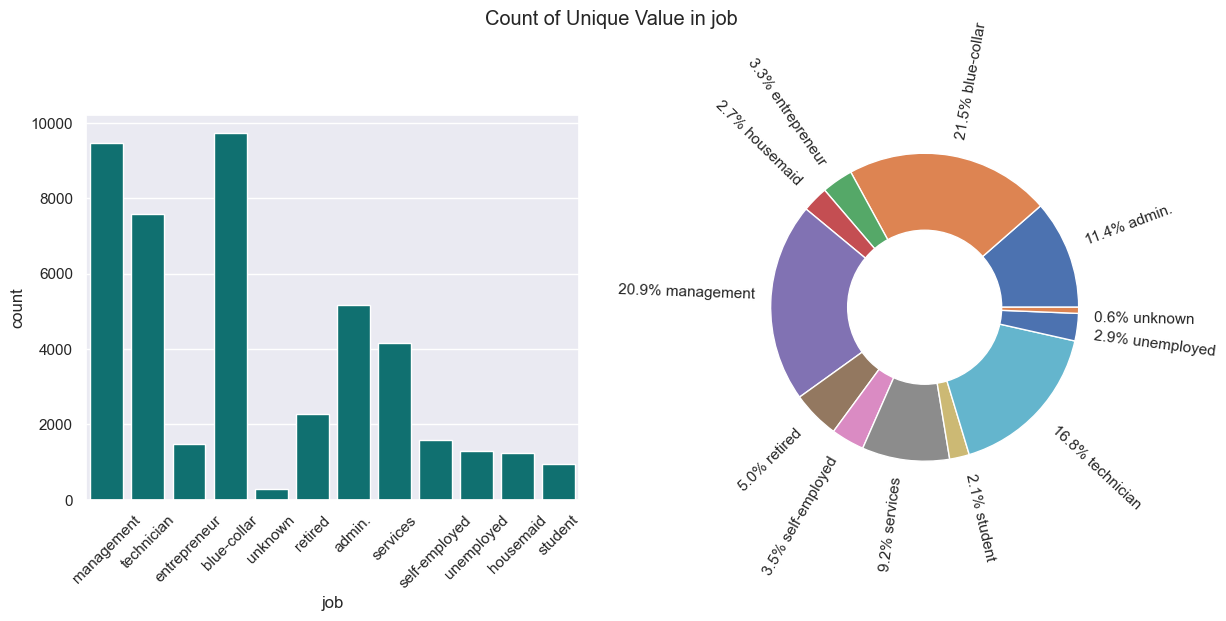

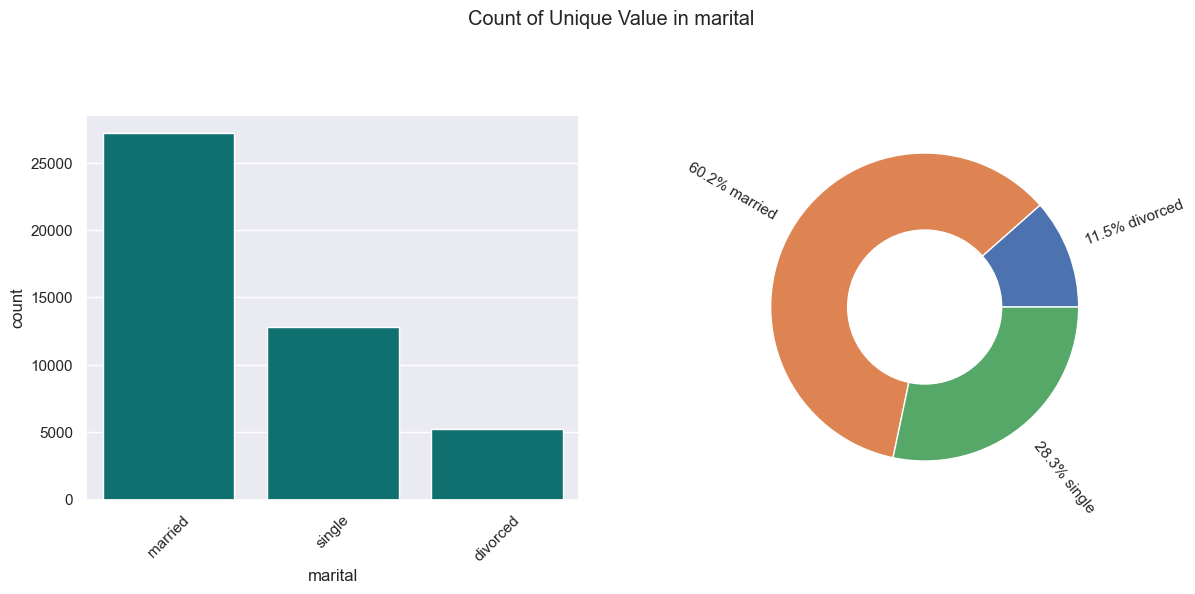

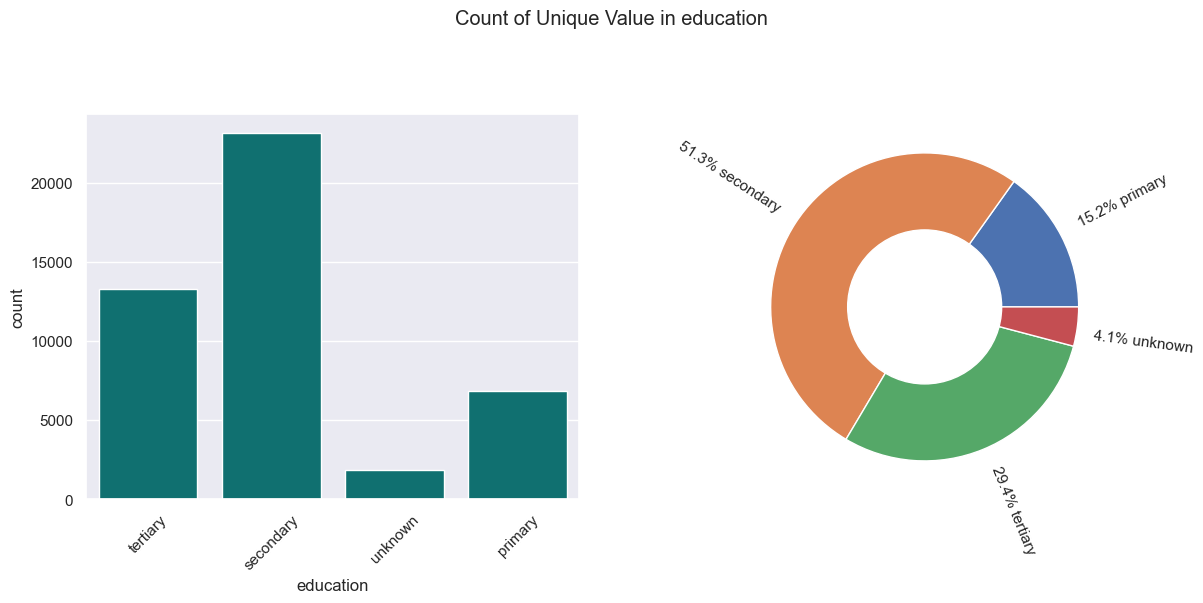

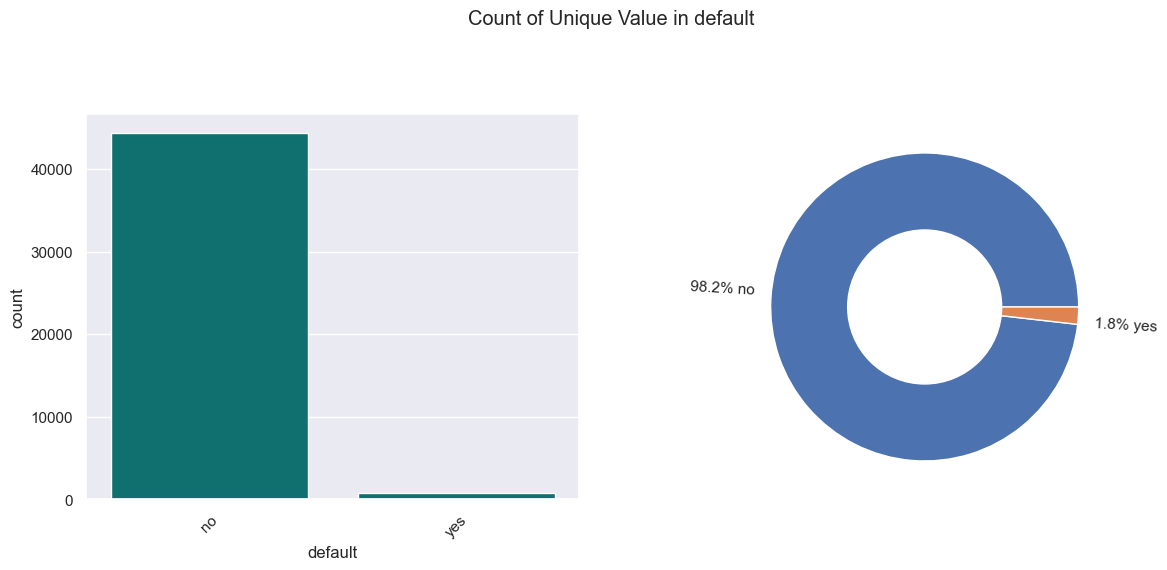

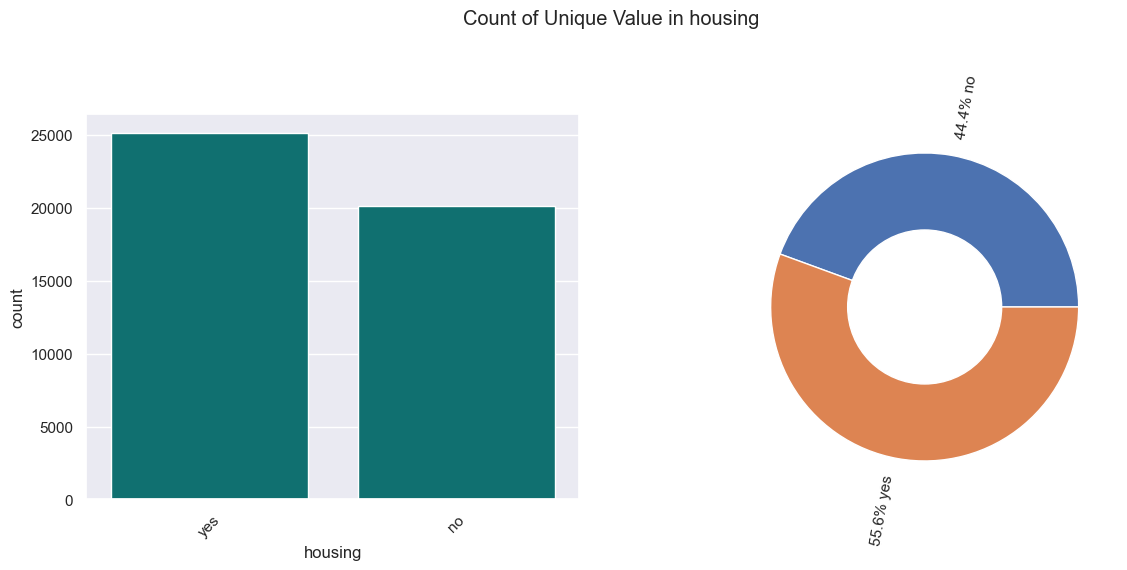

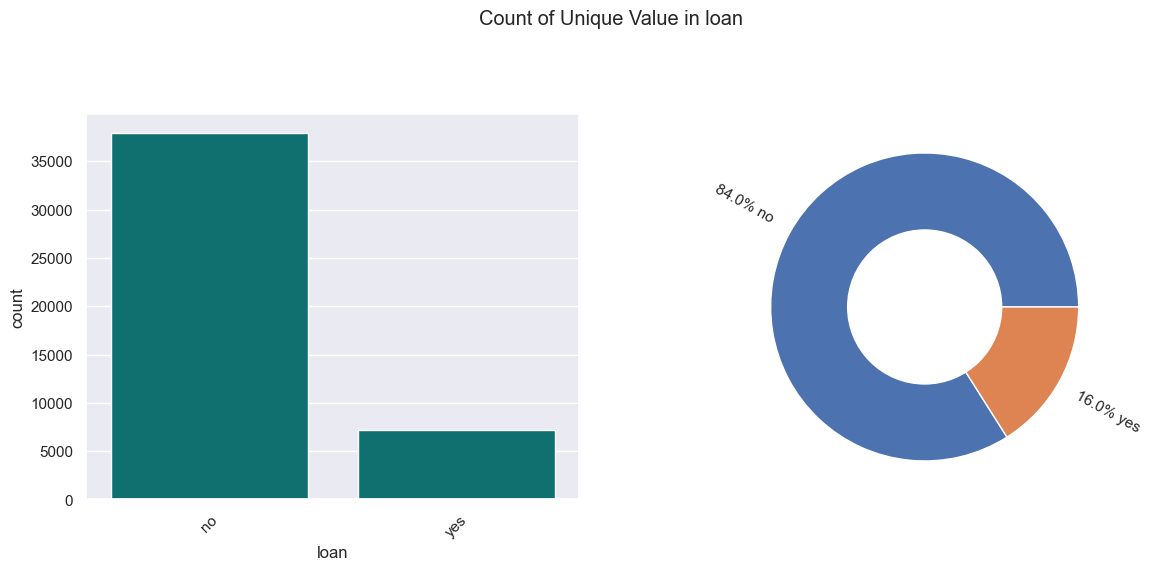

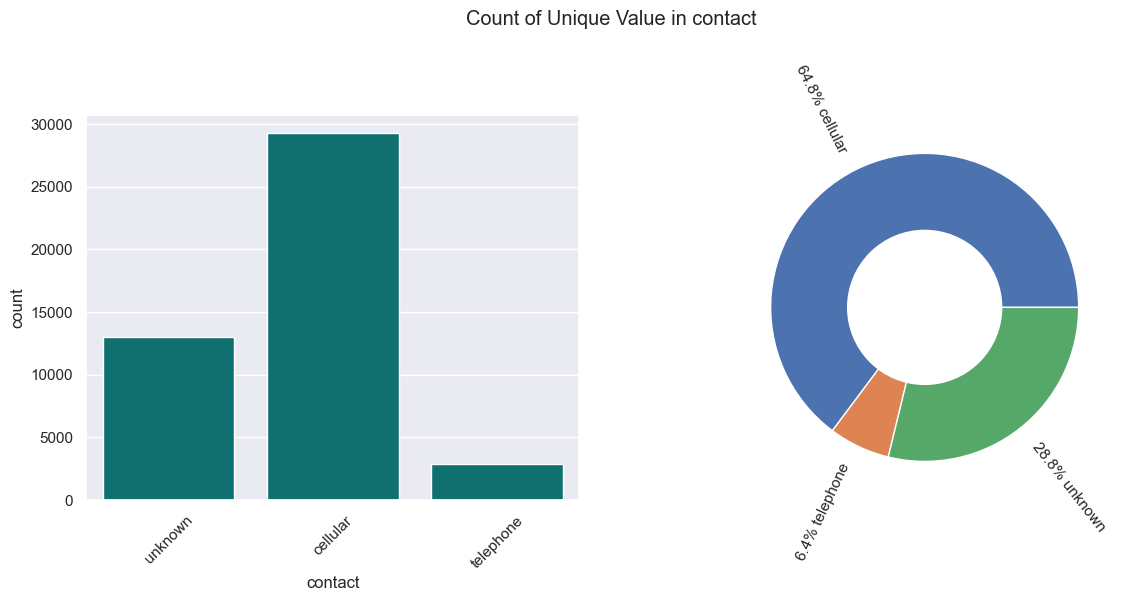

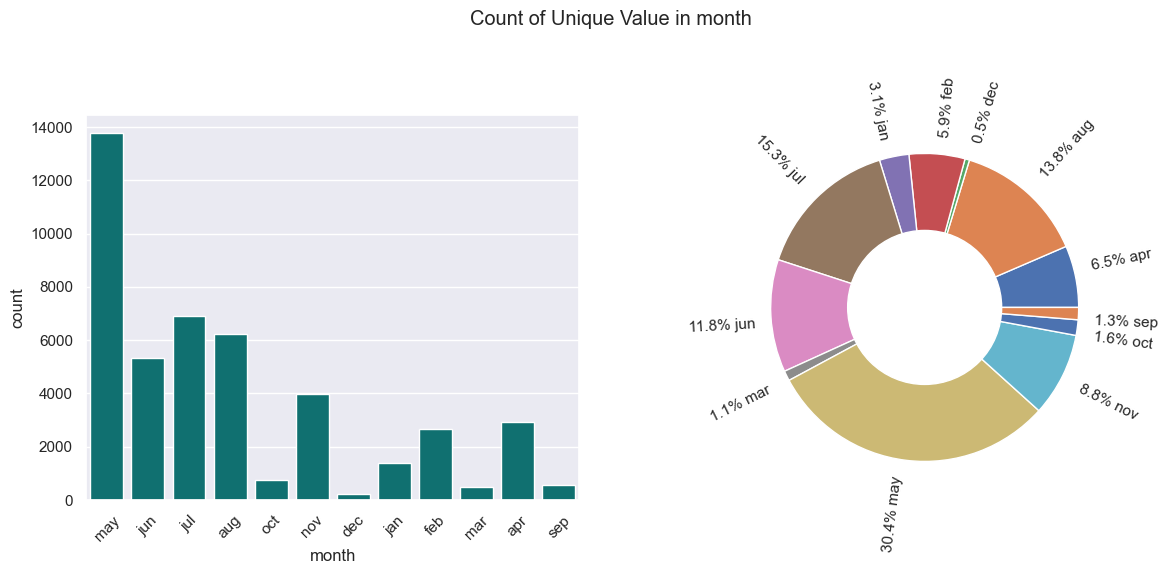

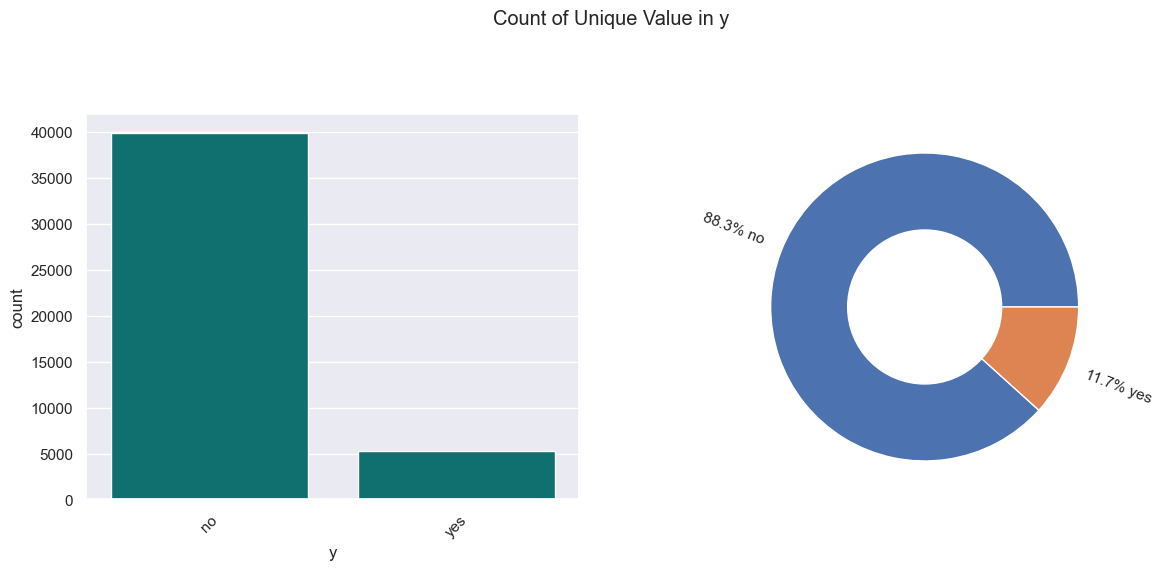

In [12]:
for i, col in enumerate(current_campaign.select_dtypes('object').columns):
    
    sns.set(style="darkgrid")
    fig, axes = plt.subplots(1,2,figsize=(14,5))

    # count of col (countplot)
    ax = sns.countplot(data=current_campaign, x=col, ax=axes[0], color='teal')
    ax.tick_params(axis='x', labelrotation = 45)
    # count of col (pie chart)
    slices = current_campaign[col].value_counts().sort_index().values
    activities = [f'{np.round(slices[i] / sum(slices) * 100, 1)}% {var}' 
                  for i, var in enumerate(current_campaign[col].value_counts().sort_index().index)]
    axes[1].pie(slices, labels=activities, shadow=False, rotatelabels=True)
    circle = plt.Circle(xy=(0,0), radius=0.5, facecolor='white')
    plt.gca().add_artist(circle)

    plt.suptitle(f'Count of Unique Value in {col}', y=1.09)
    plt.show()

In [13]:
current_campaign['y'].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

the amount of data labeled **no** is 88 percent and the amount of data labeled **yes** is 12 percent. In this case, we are dealing with class imbalance in machine learning. Next we will use such resampling methods as SMOTEENN and SMOTETomek

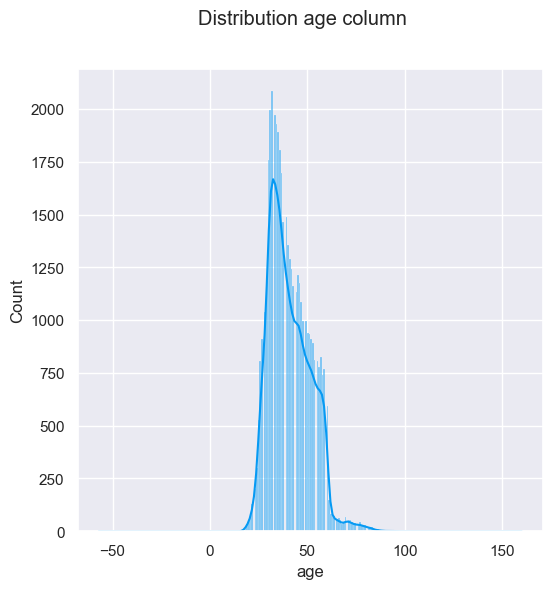

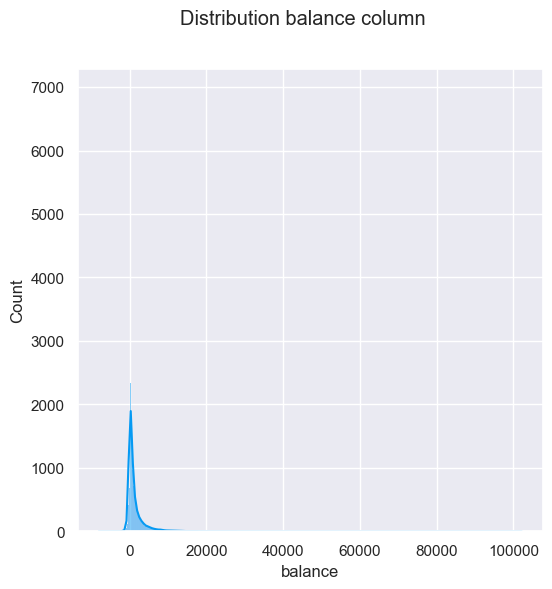

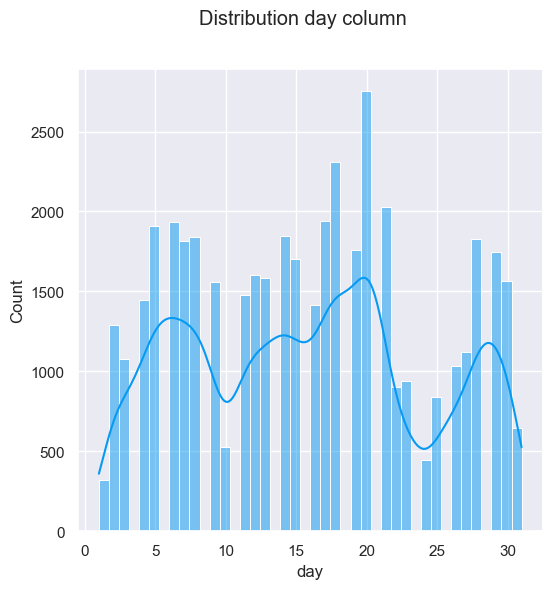

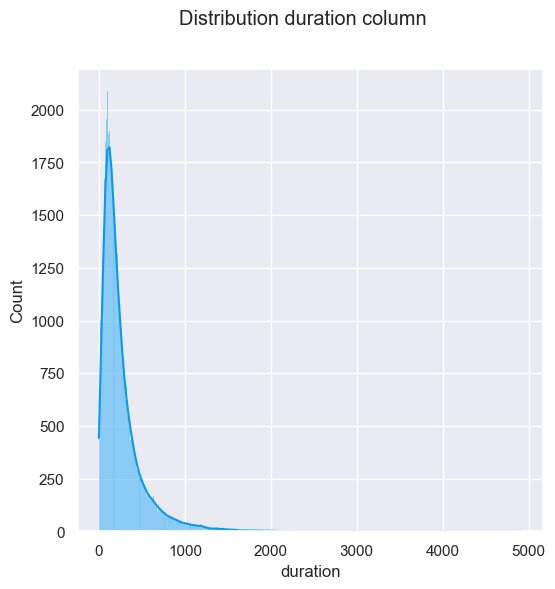

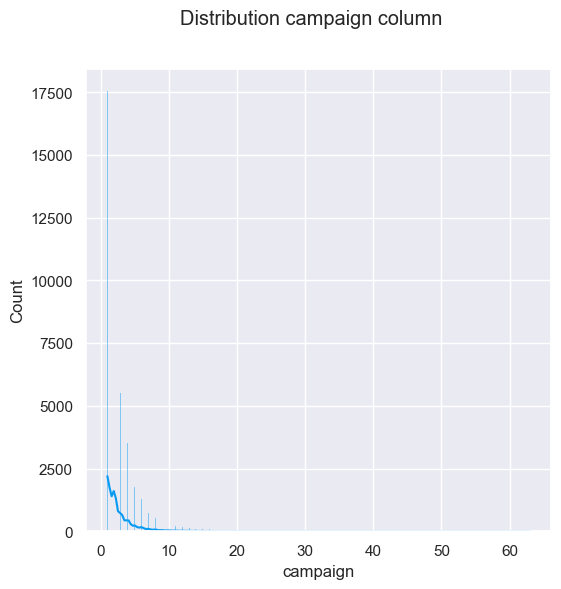

In [14]:
for i, col in enumerate(current_campaign.select_dtypes(include=['int64', 'float64']).columns):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    
    sns.histplot(data=current_campaign, x=col, color='#069AF3', kde=True)
    plt.suptitle(f'Distribution {col} column')

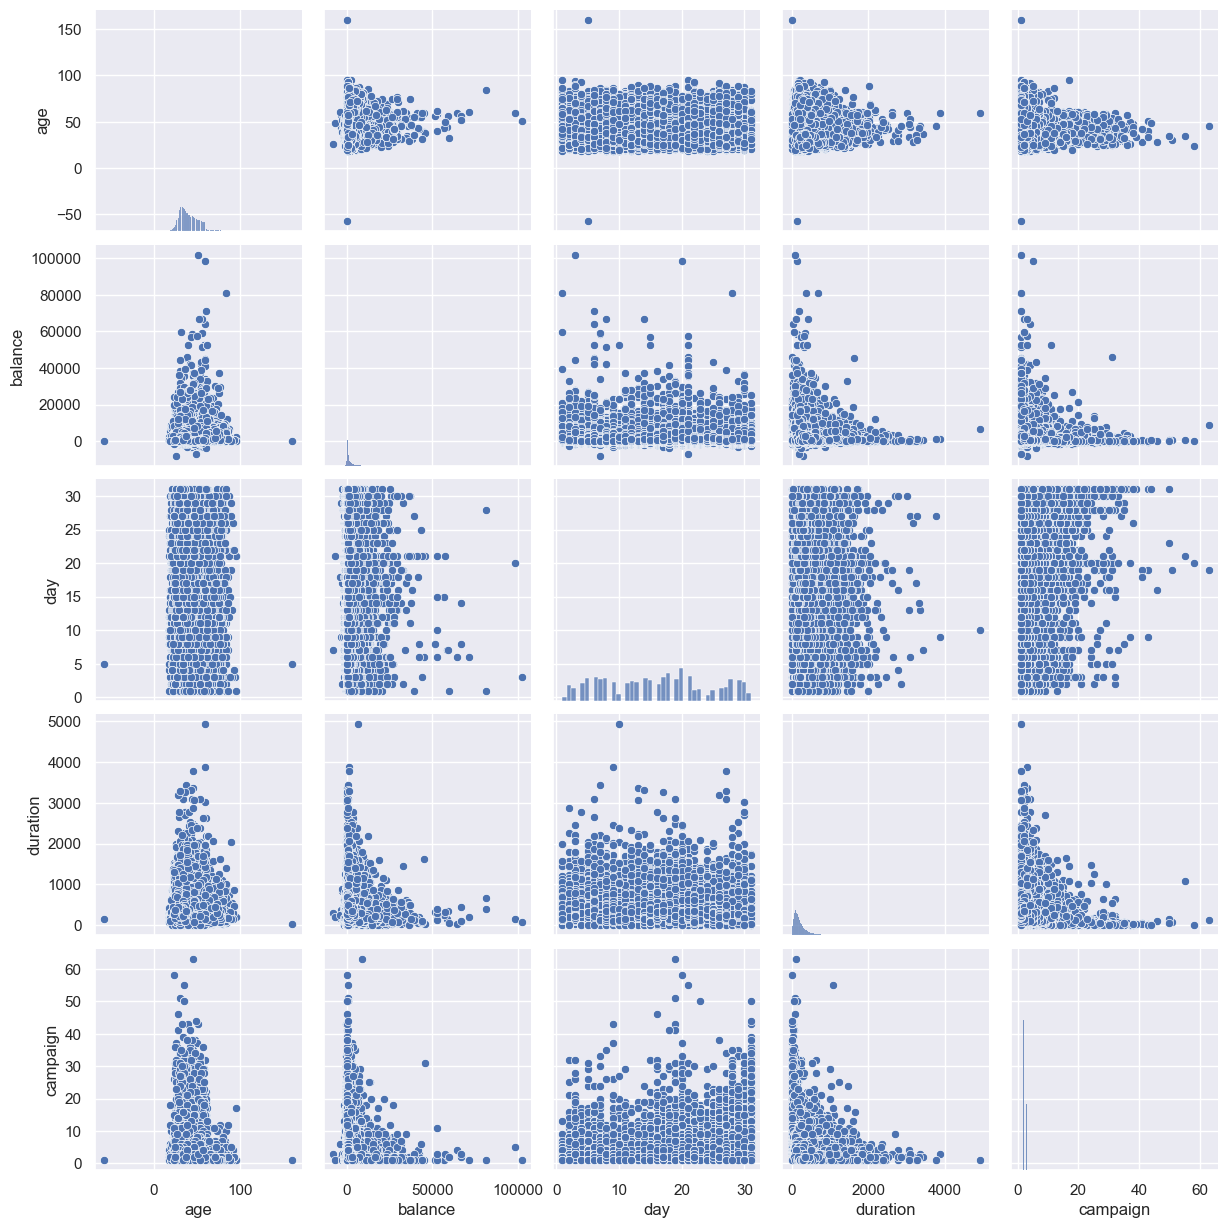

In [15]:
# Chek outliers
sns.pairplot(current_campaign.select_dtypes(include=['int64', 'float64']))

<Axes: >

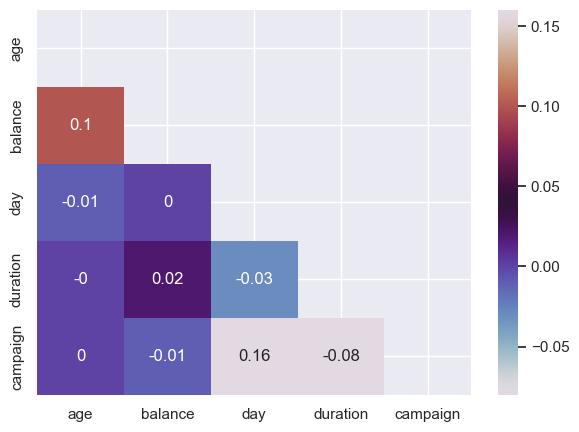

In [16]:
# Check the correlations among all the numerical features
# check the correlations between the numerical features, if the data show a high enough correlation 
# (for example, more than 0.7), we can remove one of the columns
plt.figure(figsize=(7, 5))
mask = np.triu(current_campaign.select_dtypes(include=['int64', 'float64']).corr())
corr = current_campaign.select_dtypes(include=['int64', 'float64']).corr().round(2)
sns.heatmap(corr, annot=True, cmap='twilight', mask=mask)

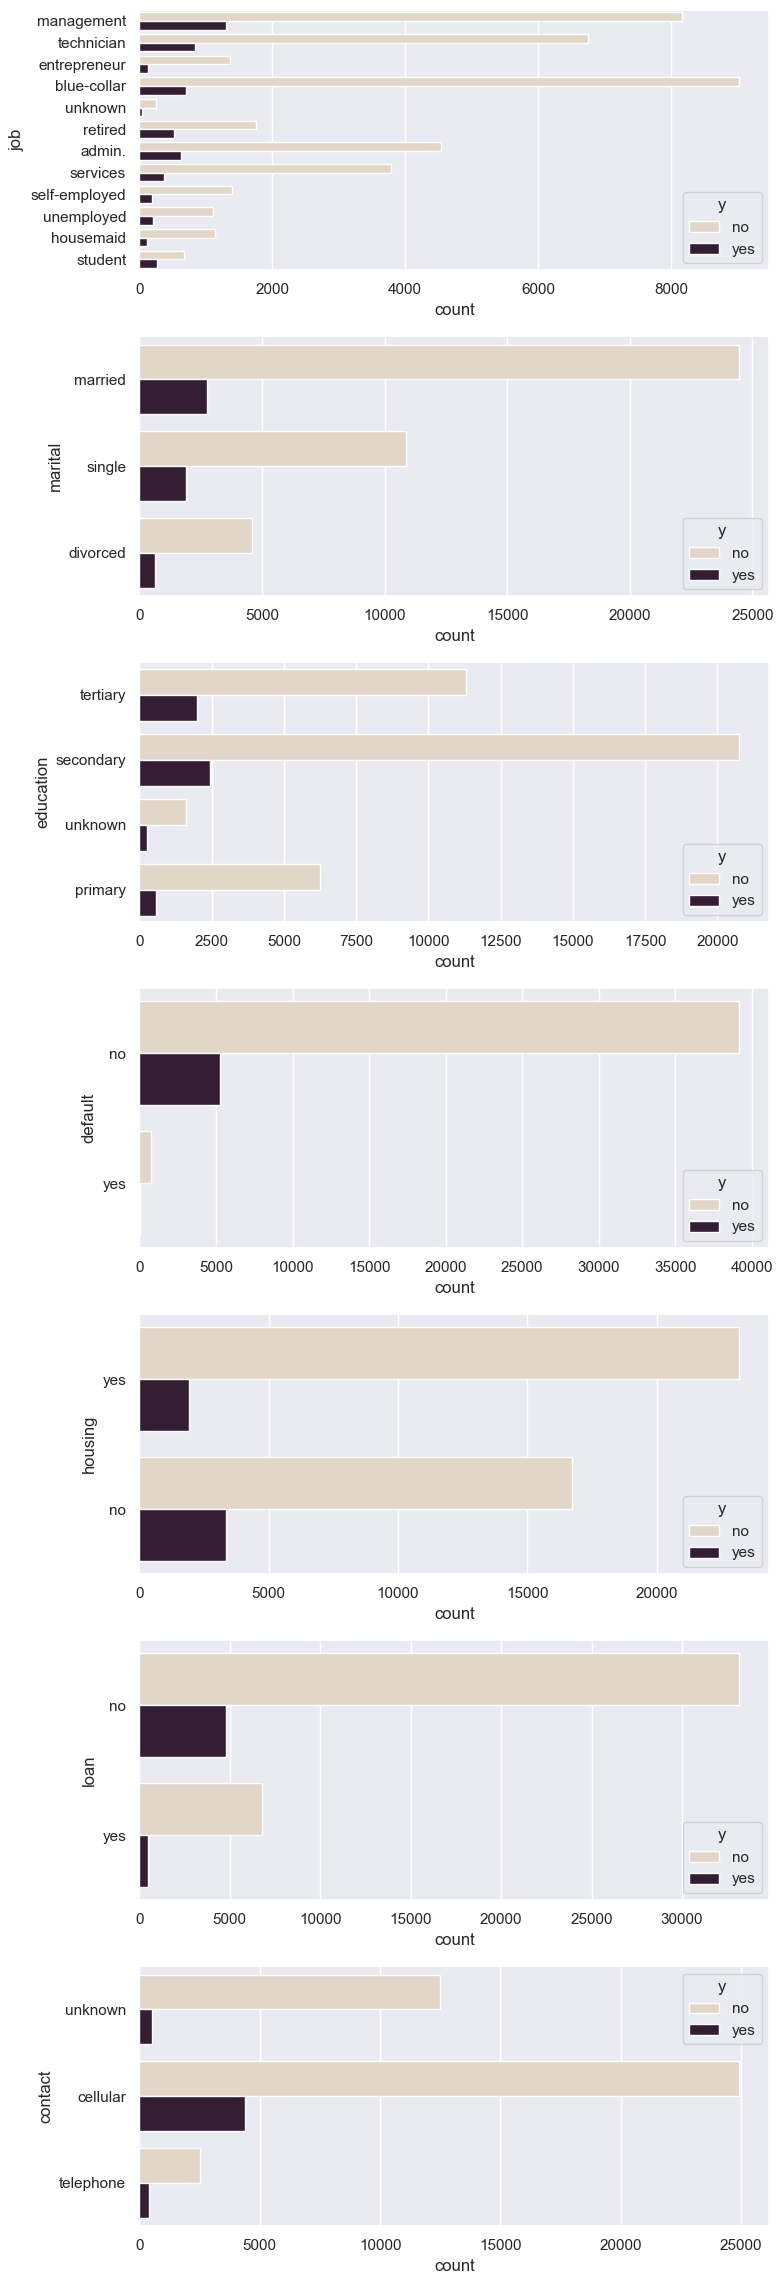

In [17]:
fig, axes = plt.subplots(7, 1, figsize=(8, 23))
axes = axes.flatten()

for ax, col in zip(axes, ['job', 'marital', 'education', 
                          'default', 'housing', 'loan',
                          'contact']):
    sns.countplot(y=col, hue='y', data=current_campaign, ax=ax, palette='ch:.25')
plt.tight_layout()
plt.show()

values in each categorical column have the highest number of labels with the value 'yes'

For example, in the 'job' column, managers have the most 'yes' labels, so it's worth looking at people working as managers 

# Processing data


## Сreate a copy / Fill in missing values

In [18]:
current_campaign_copy = current_campaign.copy()

In [19]:
current_campaign_copy[current_campaign_copy['age'].isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
111,NaN,technician,divorced,secondary,no,79,no,no,unknown,5,may,144,1,no
137,NaN,services,single,unknown,no,0,no,no,unknown,5,may,73,1,no
235,NaN,blue-collar,married,primary,no,25,yes,no,unknown,5,may,40,1,no


In [20]:
# filling in with median value
current_campaign_copy['age'] = current_campaign_copy['age'].fillna(round(current_campaign_copy['age'].median()))

In [21]:
# filling in with the most frequent value
current_campaign_copy['marital'] = current_campaign_copy['marital'].fillna('married')

In [22]:
current_campaign_copy.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

## Outliers deletion

In [23]:
index_age = current_campaign_copy[(current_campaign_copy['age'] < 0) | (current_campaign_copy['age'] > 100)].index
current_campaign_copy.drop(index_age, inplace=True)

In [24]:
# for el in current_campaign_copy.select_dtypes(include=['int64', 'float64']).columns:
#     q1 = current_campaign_copy[el].quantile(0.25)
#     q3 = current_campaign_copy[el].quantile(0.75)
#     IQR = q3 - q1
#     low_bound = q1 - 1.5 * IQR
#     up_bound = q3 + 1.5 * IQR
#     current_campaign_copy[el] = np.where(current_campaign_copy[el] < low_bound, np.nan, current_campaign_copy[el])
#     current_campaign_copy[el] = np.where(current_campaign_copy[el] > up_bound, np.nan, current_campaign_copy[el])

# current_campaign_copy.dropna(axis=0, inplace=True)

In [25]:
current_campaign_copy.shape, current_campaign.shape

((45209, 14), (45211, 14))

## Encoding

In [26]:
current_campaign_copy['y'] = current_campaign_copy['y'].replace({'no': 0, 'yes': 1})
current_campaign_copy.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
45206,51.0,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,1
45207,71.0,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,1
45208,72.0,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,1
45209,57.0,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,0
45210,37.0,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,0


In [27]:
# y, X split
y = current_campaign_copy['y']
X = current_campaign_copy.drop(columns='y')

In [28]:
# columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
# enc = TargetEncoder(cols=columns)
# features = enc.fit_transform(features, target)

In [29]:
# Target encoding
""" 
in columns 'job', 'month' we have a large number of unique values, 
so one-hot encoding here will create a large number of columns, 
which may lead to a dimensionality problem in ml, 
as well as our data will be quite sparse as it will contain a lot of zeros. 
Therefore, we will use Target encoding
"""
columns = ['education', 'job', 'month']
enc = TargetEncoder(cols=columns)
X = enc.fit_transform(X, y)

In [30]:
# One-Hot encoding
one_hot = OneHotEncoder(cols=['marital', 'default', 'housing', 'loan', 'contact'], use_cat_names=True)
X = one_hot.fit_transform(X)
X

,age,job,marital_married,marital_single,marital_divorced,education,default_no,default_yes,balance,housing_yes,housing_no,loan_no,loan_yes,contact_unknown,contact_cellular,contact_telephone,day,month,duration,campaign
0,58.0,0.137556,1,0,0,0.150075,1,0,2143,1,0,1,0,1,0,0,5,0.067199,261,1
1,44.0,0.110570,0,1,0,0.105594,1,0,29,1,0,1,0,1,0,0,5,0.067199,151,1
2,33.0,0.082717,1,0,0,0.105594,1,0,2,1,0,0,1,1,0,0,5,0.067199,76,1
3,47.0,0.072757,1,0,0,0.135776,1,0,1506,1,0,1,0,1,0,0,5,0.067199,92,1
4,33.0,0.118056,0,1,0,0.135776,1,0,1,0,1,1,0,1,0,0,5,0.067199,198,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,0.110570,1,0,0,0.150075,1,0,825,0,1,1,0,0,1,0,17,0.101511,977,3
45207,71.0,0.228016,0,0,1,0.086265,1,0,1729,0,1,1,0,0,1,0,17,0.101511,456,2
45208,72.0,0.228016,1,0,0,0.105594,1,0,5715,0,1,1,0,0,1,0,17,0.101511,1127,5
45209,57.0,0.072757,1,0,0,0.105594,1,0,668,0,1,1,0,0,0,1,17,0.101511,508,4


## Train/test split

Let's create 3 data instances **(no sampling, SMOTEENN, SMOTETomek)** to compare metrics on this data

In [31]:
tom_enc = SMOTETomek(random_state=42)
X_rs_tom, y_rs_tom = tom_enc.fit_resample(X, y)

smote_enc = SMOTEENN(random_state=42)
X_rs_smote, y_rs_smote = smote_enc.fit_resample(X, y)

In [32]:
# Tomek resampling
x_train_tom, x_test_tom, y_train_tom, y_test_tom = train_test_split(X_rs_tom, y_rs_tom, 
                                                    test_size=0.3, random_state=0)
# Smote resampling
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(X_rs_smote, y_rs_smote, 
                                                    test_size=0.3, random_state=0)
# Without sampling
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3, random_state=0)

In [33]:
scaler = MinMaxScaler()
x_train_tom = pd.DataFrame(data=scaler.fit_transform(x_train_tom), columns=x_train_tom.columns, index=x_train_tom.index)
x_test_tom = pd.DataFrame(data=scaler.transform(x_test_tom), columns=x_test_tom.columns, index=x_test_tom.index)

x_train_smote = pd.DataFrame(data=scaler.fit_transform(x_train_smote), columns=x_train_smote.columns, index=x_train_smote.index)
x_test_smote = pd.DataFrame(data=scaler.transform(x_test_smote), columns=x_test_smote.columns, index=x_test_smote.index)

x_train = pd.DataFrame(data=scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(data=scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

## Metrics

In [34]:
def show_metrics(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote, model=None):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    precision_tom = precision_score(y_test_tom, y_pred_tom)
    recall_tom = recall_score(y_test_tom, y_pred_tom)
    accuracy_tom = accuracy_score(y_test_tom, y_pred_tom)
    f1_tom = f1_score(y_test_tom, y_pred_tom)

    precision_smote = precision_score(y_test_smote, y_pred_smote)
    recall_smote = recall_score(y_test_smote, y_pred_smote)
    accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)
    f1_smote = f1_score(y_test_smote, y_pred_smote)
    
    metrics_data = pd.DataFrame(
    {'Accuracy': [accuracy, accuracy_tom, accuracy_smote],
    'Precision': [precision, precision_tom, precision_smote],
    'Recall': [recall, recall_tom, recall_smote],
    'F1': [f1, f1_tom, f1_smote]}, index=[model, f'{model}(SMOTETomek)', f'{model}(SMOTEENN)'])
    
    return metrics_data

In [35]:
def show_confusion_matrix(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote):
    cm = confusion_matrix(y_test, y_pred)
    cm_tom = confusion_matrix(y_test_tom, y_pred_tom)
    cm_smote = confusion_matrix(y_test_smote, y_pred_smote)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.set_title('Without sampling')
    ax2.set_title('SMOTETomek')
    ax3.set_title('SMOTEENN')

    axes = (ax1, ax2, ax3)
    
    for i, el in enumerate([cm, cm_tom, cm_smote]):
        sns.heatmap(el, annot=True, fmt='.2f', ax=axes[i])
        axes[i].set_xlabel('true_labels')
        axes[i].set_ylabel('prediction')

# Plot learning curve

In [36]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='recall')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Recall")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Models

## Logistic regresion

In [37]:
lr_model = LogisticRegression(penalty='l1', C=0.1, solver='saga', class_weight='balanced')
lr_model.fit(x_train, y_train)
y_probs = lr_model.predict_proba(x_test)[:, 1]
# Threshold
threshold = 0.6
# Decision-making based on a set threshold
y_pred = np.where(y_probs >= threshold, 1, 0)

lr_model_tom = LogisticRegression(penalty='l1', C=0.1, solver='saga')
lr_model_tom.fit(x_train_tom, y_train_tom)
y_pred_tom = lr_model_tom.predict(x_test_tom)

lr_model_smote = LogisticRegression(penalty='l1', C=0.1, solver='saga')
lr_model_smote.fit(x_train_smote, y_train_smote)
y_pred_smote = lr_model_smote.predict(x_test_smote)

**Changing the decision threshold in the logistic regression model increased the accuracy by 0.01 in some metrics, so I decided to leave it as is, with the threshold equal to 0.5**

In [38]:
show_metrics(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote, 'Logistic regresion')

,Accuracy,Precision,Recall,F1
Logistic regresion,0.858955,0.437066,0.713296,0.542016
Logistic regresion(SMOTETomek),0.901320,0.937305,0.862898,0.898563
Logistic regresion(SMOTEENN),0.934081,0.957008,0.924881,0.940670


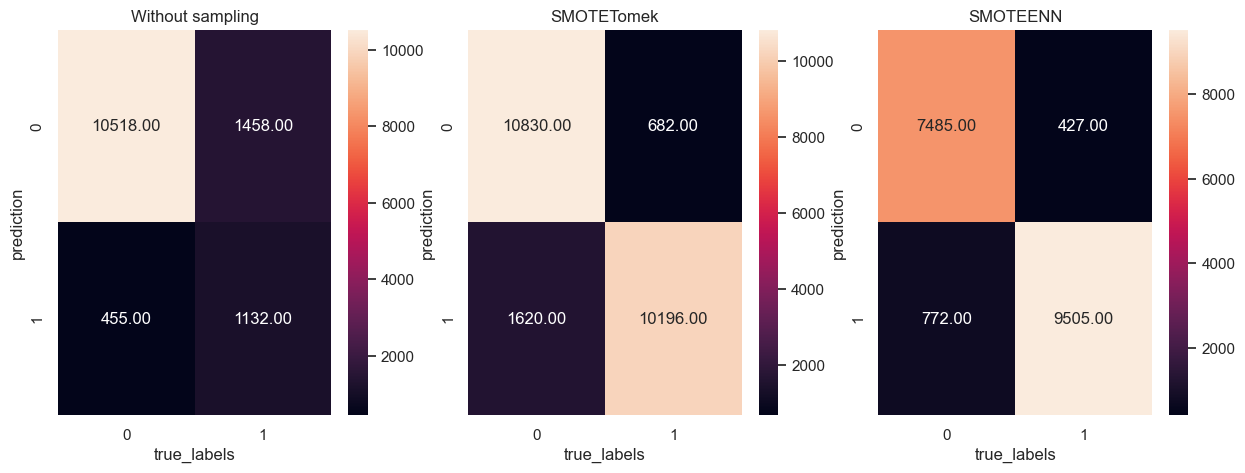

In [39]:
show_confusion_matrix(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote)

## Random Forest

In [40]:
rf_model = RandomForestClassifier(n_estimators=1100, criterion='log_loss',
                        max_depth=12, min_samples_split=2, n_jobs=-1, random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

rf_model_tom = RandomForestClassifier(n_estimators=1100, criterion='log_loss',
                        max_depth=12, min_samples_split=2, n_jobs=-1, random_state=42)
rf_model_tom.fit(x_train_tom, y_train_tom)
y_pred_tom = rf_model_tom.predict(x_test_tom)

rf_model_smote = RandomForestClassifier(n_estimators=1100, criterion='log_loss',
                        max_depth=12, min_samples_split=2, n_jobs=-1, random_state=42)
rf_model_smote.fit(x_train_smote, y_train_smote)
y_pred_smote = rf_model_smote.predict(x_test_smote)

In [41]:
show_metrics(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote, 'Random Forest')

,Accuracy,Precision,Recall,F1
Random Forest,0.896336,0.629471,0.277253,0.384952
Random Forest(SMOTETomek),0.936471,0.931951,0.943466,0.937673
Random Forest(SMOTEENN),0.958271,0.958566,0.967987,0.963253


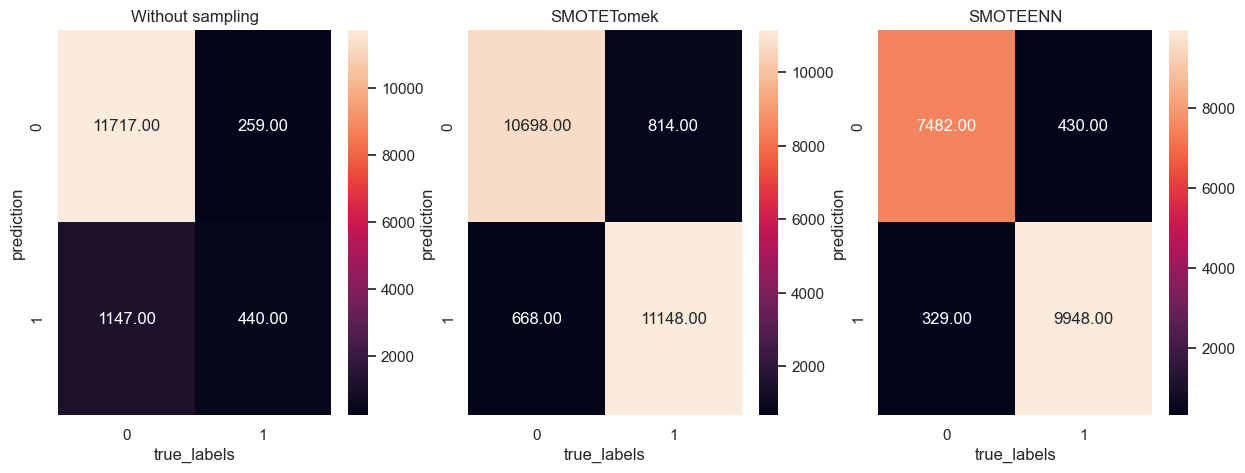

In [42]:
show_confusion_matrix(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote)

## KNN

In [43]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, weights='distance', metric='manhattan')
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)

knn_model_tom = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, weights='distance', metric='manhattan')
knn_model_tom.fit(x_train_tom, y_train_tom)
y_pred_tom = knn_model_tom.predict(x_test_tom)

knn_model_smote = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, weights='distance', metric='manhattan')
knn_model_smote.fit(x_train_smote, y_train_smote)
y_pred_smote = knn_model_smote.predict(x_test_smote)

In [44]:
show_metrics(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote, 'KNN')

,Accuracy,Precision,Recall,F1
KNN,0.885424,0.518112,0.297417,0.377902
KNN(SMOTETomek),0.930727,0.950212,0.910968,0.930176
KNN(SMOTEENN),0.945571,0.968048,0.934514,0.950985


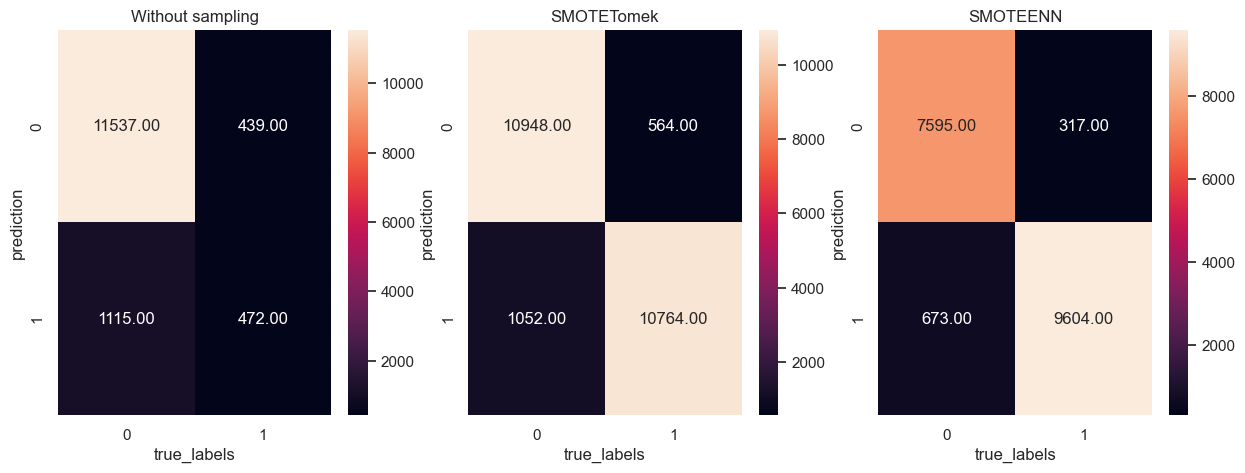

In [45]:
show_confusion_matrix(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote)

## XGBoost

In [46]:
xgb = XGBClassifier(max_depth=8, learning_rate=0.03, n_estimators=500, 
                    booster='gbtree', validate_parameters=True)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

xgb_tom = XGBClassifier(max_depth=8, learning_rate=0.03, n_estimators=500, 
                    booster='gbtree', validate_parameters=True)
xgb_tom.fit(x_train_tom, y_train_tom)
y_pred_tom = xgb_tom.predict(x_test_tom)

xgb_smote = XGBClassifier(max_depth=8, learning_rate=0.03, n_estimators=500, 
                    booster='gbtree', validate_parameters=True)
xgb_smote.fit(x_train_smote, y_train_smote)
y_pred_smote = xgb_smote.predict(x_test_smote)

In [47]:
show_metrics(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote, 'Xgboost')

,Accuracy,Precision,Recall,F1
Xgboost,0.901349,0.601302,0.465658,0.524858
Xgboost(SMOTETomek),0.946288,0.953854,0.939404,0.946574
Xgboost(SMOTEENN),0.968937,0.975426,0.969446,0.972427


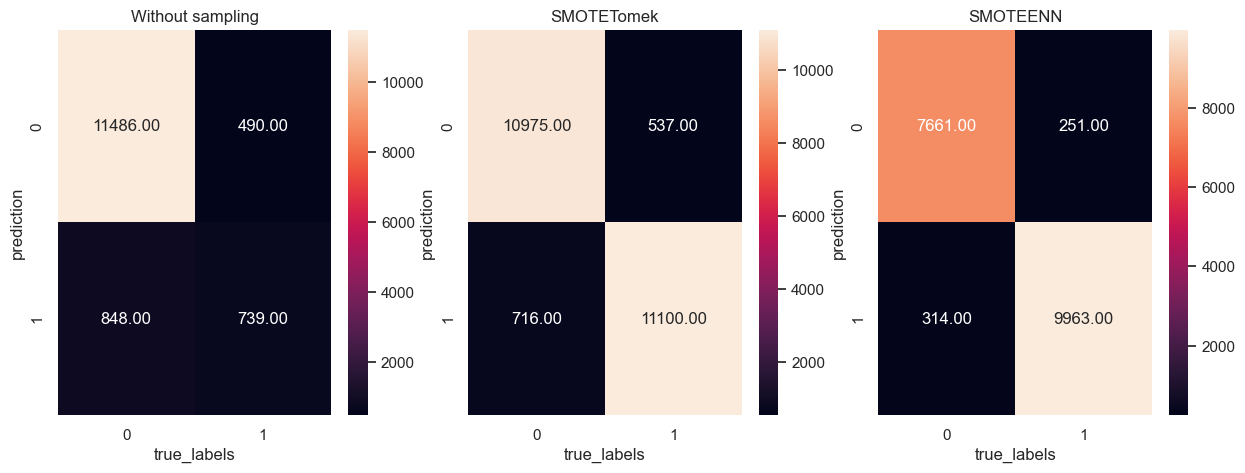

In [48]:
show_confusion_matrix(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote)

Text(0.5, 0.98, 'XGBoost')

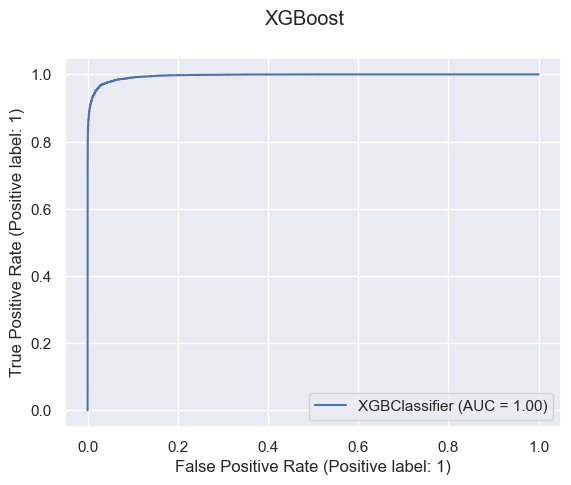

In [49]:
xgb_disp = RocCurveDisplay.from_estimator(xgb_smote, x_test_smote, y_test_smote)
plt.suptitle('XGBoost')

In [50]:
plot_learning_curve(xgb_smote, x_train_smote, y_train_smote)


KeyboardInterrupt



**our graph may be indicative of more than one fact:** 
- our model may have good generalizability.
- Also, the hyperparameters may be well chosen
- there may also be insufficient data

## Catboost

In [ ]:
catboost = CatBoostClassifier(learning_rate=0.03, iterations=900, loss_function='CrossEntropy', depth=6, verbose=False)
catboost.fit(x_train, y_train)
y_pred = catboost.predict(x_test)

catboost_tom = CatBoostClassifier(learning_rate=0.03, iterations=900, loss_function='CrossEntropy', depth=6, verbose=False)
catboost_tom.fit(x_train_tom, y_train_tom)
y_pred_tom = catboost.predict(x_test_tom)

catboost_smote = CatBoostClassifier(learning_rate=0.03, iterations=900, loss_function='CrossEntropy', depth=6, verbose=False)
catboost_smote.fit(x_train_smote, y_train_smote)
y_pred_smote = catboost.predict(x_test_smote)

In [ ]:
show_metrics(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote, 'Catboost')

In [ ]:
show_confusion_matrix(y_test, y_pred, y_test_tom, y_pred_tom, y_test_smote, y_pred_smote)

# Choose hyperparameters

In [ ]:
logreg_params = dict(C=loguniform(1e-1, 1e2), 
                     penalty=['l1', 'l2'], 
                    solver=['saga', 'liblinear', 'lbfgs'])

In [ ]:
knn_params = dict(n_neighbors=[2, 4, 6, 8, 10, 12, 14, 20],
               weights=['uniform', 'distance'],
               metric=['euclidean', 'manhattan'])

In [ ]:
rf_params = dict(n_estimators=[i for i in range(500, 1201, 150)],
                 criterion=['log_loss', 'entropy'], 
                 max_depth=[4, 6, 8, 10, 12], 
                 min_samples_split=[2, 4, 6, 8, 10])

In [ ]:
xgb_params = dict(max_depth=[4, 6, 8, 10, 12],
                  learning_rate=[0.01, 0.03, 0.05, 0.07, 0.09, 0.1],
                  n_estimators=[i for i in range(500, 1501, 200)],
                  booster=['gbtree', 'gblinear'])

In [ ]:
cat_params = dict(learning_rate=[0.01, 0.03, 0.05, 0.07, 0.09, 0.1],
                  iterations=[i for i in range(500, 1501, 200)],
                  loss_function=['Logloss', 'CrossEntropy', 'F1'],
                  depth=[4, 6, 8, 10])

In [ ]:
clf_list = [lr_model, knn_model, rf_model, xgb, catboost]
params_list = [logreg_params, knn_params, rf_params, xgb_params, cat_params]
model_names = ['Logistic Regression', 'KNN', 'Random Forest',
               'XGB', 'Catboost']

In [ ]:
def train_model(X, y, model_suffix, clf_list=clf_list, params_list=params_list):
    for i in range(len(clf_list)):
        # model training with RandomizedSearchCV
        rscv = RandomizedSearchCV(estimator=clf_list[i],
                                  param_distributions=params_list[i],
                                  n_jobs=-1, random_state=42).fit(X, y)
        # store cv results
        globals()['rscv%s' % model_suffix[i]] = pd.DataFrame(rscv.cv_results_)
        # store the best model
        globals()['best%s' % model_suffix[i]] = rscv

In [ ]:
def record_best_result(model_list, model_suffix):
    # store the best results into a dataframe
    for i in range(len(model_list)):
        globals()['df%s' % model_suffix[i]] = model_list[i].query('rank_test_score == 1')\
        [['params', 'mean_test_score', 'std_test_score']]

In [ ]:
def model_eval(clf_list, model_names, x_test, y_test):
    test_acc = []
    f1_score = []
    for clf in clf_list:
        test_acc.append(clf.score(x_test, y_test))
        f1_score.append(metrics.f1_score(y_test, clf.predict(x_test)))
    return pd.DataFrame(data={'model': model_names, 'test_acc': test_acc, 'f1_score': f1_score})

In [ ]:
# train models
model_suffix_a = ['_logreg_a', '_dt_a', '_bnb_a', '_knn_a', '_lsvm_a']
train_model(x_train, y_train, model_suffix_a)

# record best results in cross validation
rscv_list_a = [rscv_logreg_a, rscv_dt_a, rscv_bnb_a, rscv_knn_a, rscv_lsvm_a]
record_best_result(rscv_list_a, model_suffix_a)

# output the best results as a dataframe
df_list_a = [df_logreg_a, df_dt_a, df_bnb_a, df_knn_a, df_lsvm_a]
for df, model in zip(df_list_a, model_names):
    df['model'] = model
result_df_a = pd.concat(df_list_a)

# check test scores
best_clfs_a = [best_logreg_a, best_dt_a, best_bnb_a, best_knn_a, best_lsvm_a]
test_result_a = model_eval(best_clfs_a, model_names, x_test, y_test)

In [ ]:
result_df_a

In [ ]:
test_result_a

In [ ]:
for par in result_df_a['params']:
    print(par)

# Most important features

## XGBOOST SMOTEENN

In [ ]:

feature_importances = xgb_smote.feature_importances_

# Create a list of tuples containing feature names and their corresponding importances
feature_importance_tuples = [(feature, importance) for feature, importance in zip(X.columns, feature_importances)]

# Sort the list of tuples based on feature importances in descending order
sorted_feature_importances = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Print the features with their importances
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")
    
    
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb_smote, importance_type='gain', max_num_features=10)
plt.show()

## Logistic Regression SMOTEENN

In [ ]:
# Print the values of the coefficients and their corresponding signs
result = zip(X.columns, lr_model_smote.coef_[0])
for feature, coef in result:
    print(f"Feature: {feature}, Coefficient: {coef}")